In [ ]:
import torch
import torchvision
import numpy
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
!pip install pytorch_lightning

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_test =  pd.DataFrame(scaler.transform(X_test))



In [ ]:
pd.DataFrame(y_train).iloc[0].to_list()

[1]

In [ ]:
log_dict = {
    "train_loss":[],
    "train_auc":[],
    "val_loss":[],
    "val_auc":[]
}

In [ ]:
class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        dense1 = nn.Linear(input_dim, hidden_size, bias=False)
        self.dense1 = nn.utils.weight_norm(dense1)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = conv1 = nn.Conv1d(
            cha_input, 
            cha_input*K, 
            kernel_size=5, 
            stride = 1, 
            padding=2,  
            groups=cha_input, 
            bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            cha_input*K, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        conv3 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv3 = nn.utils.weight_norm(conv3, dim=None)
        

        # 4th conv layer
        self.batch_norm_c4 = nn.BatchNorm1d(cha_hidden)
        conv4 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=5, 
            stride=1, 
            padding=2, 
            groups=cha_hidden, 
            bias=False)
        self.conv4 = nn.utils.weight_norm(conv4, dim=None)

        self.avg_po_c4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm2 = nn.BatchNorm1d(output_size)
        self.dropout2 = nn.Dropout(dropout_output)
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.loss = nn.BCEWithLogitsLoss()

        self.log_dict = {
            "train_loss":[],
            "train_auc":[],
            "val_loss":[],
            "val_auc":[]
            }
        
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = nn.functional.celu(self.dense1(x))

        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)

        x = self.batch_norm_c1(x)
        x = nn.functional.relu(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = nn.functional.relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = nn.functional.relu(self.conv3(x))

        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        x =  x + x_s
        x = nn.functional.relu(x)

        x = self.avg_po_c4(x)

        x = self.flt(x)

        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.dense2(x)

        return x

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return {"loss":loss, "y_hat":y_hat, "y":y, "batch_loss":loss.item() * X.size(0)}

    def training_epoch_end(self, train_step_outputs):
        # log epoch metric
        # self.log('train_acc_epoch', self.accuracy)
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)

        y_probs = torch.sigmoid(y_hat).detach().cpu().numpy()
        metric = roc_auc_score(y.cpu().numpy(), y_probs)
        self.log_dict["train_auc"].append(metric)
        self.log_dict["train_loss"].append(epoch_loss)

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss(y_hat, y)
        self.log('valid_loss', loss)
        return {"loss":loss, "y_hat":y_hat, "y":y, "batch_loss":loss.item() * X.size(0)}

    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)

        y_probs = torch.sigmoid(y_hat).detach().cpu().numpy()
        metric = roc_auc_score(y.cpu().numpy(), y_probs)
        self.log_dict["val_loss"].append(epoch_loss)
        self.log_dict["val_auc"].append(metric)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_logit = self.forward(X)
        y_probs = torch.sigmoid(y_logit).detach().cpu().numpy()
        loss = self.loss(y_logit, y)
        metric = roc_auc_score(y.cpu().numpy(), y_probs)
        self.log('test_loss', loss)
        self.log('test_metric', metric)
        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4, momentum=0.9)
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer, 
                mode="min", 
                factor=0.5, 
                patience=5, 
                min_lr=1e-5),
            'interval': 'epoch',
            'frequency': 1,
            'reduce_on_plateau': True,
            'monitor': 'valid_loss',
        }
        return [optimizer], [scheduler]
    
    def get_logs(self):
      return self.log_dict

In [ ]:
from torch.utils.data import DataLoader,TensorDataset
train_tensor_dset = TensorDataset(
    torch.tensor(X_train.values, dtype=torch.float),
    torch.tensor(pd.DataFrame(y_train).values.reshape(-1,1), dtype=torch.float)
)

valid_tensor_dset = TensorDataset(
    torch.tensor(X_test.values, dtype=torch.float),
    torch.tensor(pd.DataFrame(y_test).values.reshape(-1,1), dtype=torch.float)
)

In [ ]:
model = SoftOrdering1DCNN(
    input_dim=len(X_train.columns), 
    output_dim=1, 
    sign_size=16, 
    cha_input=64, 
    cha_hidden=64, 
    K=2, 
    dropout_input=0.3, 
    dropout_hidden=0.3, 
    dropout_output=0.2
)

In [ ]:
# https://maxinterview.com/code/pytorch-lightning-save-checkpoint-every-epoch-807562644CE3D40/
early_stop_callback = EarlyStopping(
   monitor='valid_loss',
   min_delta=.0,
   patience=21,
   verbose=True,
   mode='min'
)
class CheckpointEveryEpoch(pl.Callback):
    def __init__(self, start_epoc, save_path):
        self.start_epoc = start_epoc
        self.save_path = save_path

    def on_epoch_end(self, trainer: pl.Trainer, _):
        """ Check if we should save a checkpoint after every train epoch """
        epoch = trainer.current_epoch
        # if epoch >= self.start_epoc:
        ckpt_path = f"{self.save_path}_e{epoch}.ckpt"
        trainer.save_checkpoint(ckpt_path)

epoch = 20
# trainer = Trainer(callbacks=[CheckpointEveryEpoch(2, args.save_path)]
trainer = pl.Trainer(callbacks=[early_stop_callback, CheckpointEveryEpoch(1, "/content/lightning_logs")], min_epochs=10, max_epochs=epoch, gpus=1, accelerator="cpu")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
len(DataLoader(train_tensor_dset, batch_size=8, shuffle=True, num_workers=4))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


50

In [ ]:
trainer.fit(
    model, 
    DataLoader(train_tensor_dset, batch_size=16, shuffle=True, num_workers=4),
    DataLoader(valid_tensor_dset, batch_size=16, shuffle=False, num_workers=4)
)

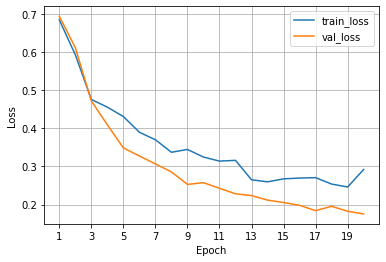

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor="white")
ax = fig.add_subplot(111, xlabel="Epoch", ylabel='Loss')

ax.plot(range(1, epoch+1), model.get_logs()["train_loss"], label="train_loss")
ax.plot(range(1, epoch+1), model.get_logs()["val_loss"][:-1], label="val_loss")
ax.grid(axis='both')
ax.legend()  # 凡例表示
ax.xaxis.set_ticks(np.arange(1, 21, 2))

fig.show()
# https://qiita.com/nkay/items/d1eb91e33b9d6469ef51

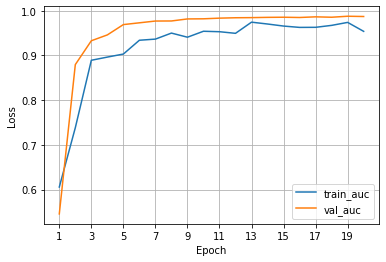

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor="white")
ax = fig.add_subplot(111, xlabel="Epoch", ylabel='Loss')

ax.plot(range(1, epoch+1), model.get_logs()["train_auc"], label="train_auc")
ax.plot(range(1, epoch+1), model.get_logs()["val_auc"][:-1], label="val_auc")
ax.grid(axis='both')
ax.legend()  # 凡例表示
ax.xaxis.set_ticks(np.arange(1, 21, 2))

fig.show()
# https://qiita.com/nkay/items/d1eb91e33b9d6469ef51

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/lightning_logs/version_2
# https://tech.jxpress.net/entry/2021/11/17/112214#%E7%B5%90%E6%9E%9C%E3%81%AE%E8%A1%A8%E7%A4%BA

In [ ]:
dataset = load_breast_cancer()
print(dataset.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [ ]:
conv1_1 = np.array(model.state_dict()['conv2.weight_v'])[0]


In [ ]:
conv1_1.shape

(128, 3)

In [ ]:
keys_list = torch.load(model_path)["state_dict"].keys()
print(keys_list)

odict_keys(['batch_norm1.weight', 'batch_norm1.bias', 'batch_norm1.running_mean', 'batch_norm1.running_var', 'batch_norm1.num_batches_tracked', 'dense1.weight_g', 'dense1.weight_v', 'batch_norm_c1.weight', 'batch_norm_c1.bias', 'batch_norm_c1.running_mean', 'batch_norm_c1.running_var', 'batch_norm_c1.num_batches_tracked', 'conv1.weight_g', 'conv1.weight_v', 'batch_norm_c2.weight', 'batch_norm_c2.bias', 'batch_norm_c2.running_mean', 'batch_norm_c2.running_var', 'batch_norm_c2.num_batches_tracked', 'conv2.weight_g', 'conv2.weight_v', 'batch_norm_c3.weight', 'batch_norm_c3.bias', 'batch_norm_c3.running_mean', 'batch_norm_c3.running_var', 'batch_norm_c3.num_batches_tracked', 'conv3.weight_g', 'conv3.weight_v', 'batch_norm_c4.weight', 'batch_norm_c4.bias', 'batch_norm_c4.running_mean', 'batch_norm_c4.running_var', 'batch_norm_c4.num_batches_tracked', 'conv4.weight_g', 'conv4.weight_v', 'batch_norm2.weight', 'batch_norm2.bias', 'batch_norm2.running_mean', 'batch_norm2.running_var', 'batch_no

In [ ]:
weight_list = []
for dic in keys_list:
  if "weight_v" in dic:
    print(dic)
    weight_list.append(dic)

dense1.weight_v
conv1.weight_v
conv2.weight_v
conv3.weight_v
conv4.weight_v
dense2.weight_v


In [ ]:
model.state_dict()["conv2.weight_v"]
# np.array(model.state_dict()["conv2.weight_g"]).shape

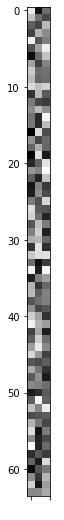

In [ ]:
plt.figure(figsize=(3.0, 9.0), facecolor="white")

plt.imshow(conv1_1.reshape(conv1_1.shape), cmap='gray')
# plt.yticks(np.arange(0, len(conv1_1) + 1 , 1), dataset.feature_names)
plt.xticks(color="None")

plt.show()
# https://tech-market.org/matplotlib-memori-mozi/

/content/lightning_logs_e0.ckpt
/content/lightning_logs_e1.ckpt
/content/lightning_logs_e2.ckpt
/content/lightning_logs_e3.ckpt
/content/lightning_logs_e4.ckpt
/content/lightning_logs_e5.ckpt
/content/lightning_logs_e6.ckpt
/content/lightning_logs_e7.ckpt
/content/lightning_logs_e8.ckpt
/content/lightning_logs_e9.ckpt
/content/lightning_logs_e10.ckpt
/content/lightning_logs_e11.ckpt
/content/lightning_logs_e12.ckpt
/content/lightning_logs_e13.ckpt
/content/lightning_logs_e14.ckpt
/content/lightning_logs_e15.ckpt
/content/lightning_logs_e16.ckpt
/content/lightning_logs_e17.ckpt
/content/lightning_logs_e18.ckpt
/content/lightning_logs_e19.ckpt


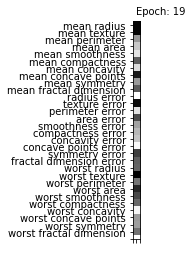

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111)
#Line2D objectを入れるリスト
ims = []

for i in range(epoch):
    model_path = f"/content/lightning_logs_e{i}.ckpt"
    print(model_path)
    conv1_1 = np.array(torch.load(model_path)["state_dict"]['dense1.weight_v'])[0]
    im = plt.imshow(conv1_1.reshape(len(conv1_1), 1), cmap='gray')
    Text = ax.text(0,-1.5, f"Epoch: {i}")
    option1 = plt.yticks(np.arange(0, len(conv1_1) + 1 , 1), dataset.feature_names)
    option2 = plt.xticks(color="None")
    ims.append([im] + [Text]) 

#アニメの生成
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

#保存
ani.save("sample.gif", writer="pillow")

#表示
plt.show()

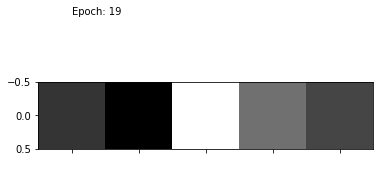

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
#Line2D objectを入れるリスト
ims = []
weight = weight_list[1]
for i in range(epoch):
    model_path = f"/content/lightning_logs_e{i}.ckpt"
    conv1_1 = np.array(torch.load(model_path)["state_dict"][f'{weight}'])[0]
    im = plt.imshow(conv1_1, cmap='gray')
    Text = ax.text(0,-1.5, f"Epoch: {i}")
    option2 = plt.xticks(color="None")
    ims.append([im] + [Text]) 

#アニメの生成
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

#保存
ani.save(f"sample_{weight}.gif", writer="pillow")

#表示
plt.show()

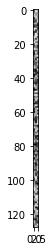

In [ ]:
model_path = f"/content/lightning_logs_e{19}.ckpt"
conv1_1 = np.array(torch.load(model_path)["state_dict"][f'conv2.weight_v'])[0]
im = plt.imshow(conv1_1, cmap='gray')
model_path = f"/content/lightning_logs_e{0}.ckpt"
conv1_2 = np.array(torch.load(model_path)["state_dict"][f'conv2.weight_v'])[0]
im = plt.imshow(conv1_1, cmap='gray')

In [ ]:
conv1_1 - conv1_2


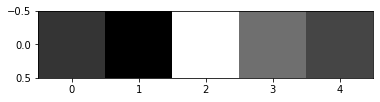

In [ ]:
model_path = f"/content/lightning_logs_e{0}.ckpt"
conv1_1 = np.array(torch.load(model_path)["state_dict"][f'conv2.weight_v'])[0]
im = plt.imshow(conv1_1, cmap='gray')

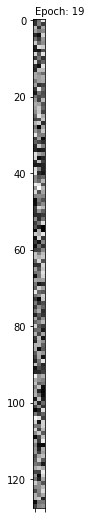

In [ ]:
fig = plt.figure(figsize=(3.0, 9.0))
ax = fig.add_subplot(111)
#Line2D objectを入れるリスト
ims = []
weight = weight_list[2]
for i in range(epoch):
    model_path = f"/content/lightning_logs_e{0}.ckpt"
    conv1_1 = np.array(torch.load(model_path)["state_dict"][f'{weight}'])[0]
    im = plt.imshow(conv1_1, cmap='gray')
    Text = ax.text(0,-1.5, f"Epoch: {i}")
    option2 = plt.xticks(color="None")
    ims.append([im] + [Text]) 

#アニメの生成
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

#保存
ani.save(f"sample_{weight}.gif", writer="pillow")

#表示
plt.show()

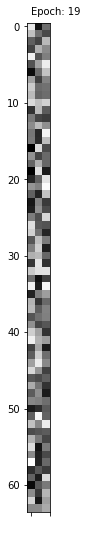

In [ ]:
fig = plt.figure(figsize=(3.0, 9.0))
ax = fig.add_subplot(111)
#Line2D objectを入れるリスト
ims = []
weight = weight_list[3]
for i in range(epoch):
    model_path = f"/content/lightning_logs_e{0}.ckpt"
    conv1_1 = np.array(torch.load(model_path)["state_dict"][f'{weight}'])[0]
    im = plt.imshow(conv1_1, cmap='gray')
    Text = ax.text(0,-1.5, f"Epoch: {i}")
    option2 = plt.xticks(color="None")
    ims.append([im] + [Text]) 

#アニメの生成
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

#保存
ani.save(f"sample_{weight}.gif", writer="pillow")

#表示
plt.show()

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle = True, num_workers = 2)

In [ ]:
torchvision.datasets.CIFAR10(download = True)


TypeError: ignored